## Problem Statement

The Billboard Top 100 is a list of the most popular songs based on sales and airplay time. Given a dataset of the Billboard Top 100 list for the year 2000, I propose that the popularity of a given track or genre can be assessed by measuring how high it ranks during its time on the list, how fast it reaches its peak, and how many weeks it stays in the top 100. Certain tracks or genres may peak quickly, but have little staying power on the list, while others may not rank significantly higher than average, but have a long tenure in the top 100. It may also be worthwhile to look for seasonal trends in when songs hit their peak. Identifying which genres fall into which of these categories will provide insight into the tastes of music listeners in the year 2000.

## Preview of Initial Dataset

The data contains 317 songs that ranked in Billboard's Top 100 list in the year 2000. Each row includes song title, artist, duration, genre, the date it first entered the list, the date it reached its highest ranking, and then its ranking for 76 weeks ranging from June 1999 - December 2000. (If a song's entry date was in 1999, but it remained on the list into 2000, it is still included.) 

This is a very wide dataset, with one column for each of the 76 weeks containing a song's rank in that week. If the song wasn't in the top 100 that week, it gets 'NaN'.

In [757]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import datetime
# Read in billboard.csv as a data frame
billboard = pd.read_csv("/Users/teresaborcuch/DSI-course-materials/curriculum/04-lessons/week-02/2.4-lab/assets/datasets/billboard.csv")
billboard.head()

year      artist.inverted                                  track  time  \
0  2000      Destiny's Child               Independent Women Part I  3:38   
1  2000              Santana                           Maria, Maria  4:18   
2  2000        Savage Garden                     I Knew I Loved You  4:07   
3  2000              Madonna                                  Music  3:45   
4  2000  Aguilera, Christina  Come On Over Baby (All I Want Is You)  3:38   

  genre date.entered date.peaked  x1st.week  x2nd.week  x3rd.week     ...      \
0  Rock   2000-09-23  2000-11-18         78       63.0       49.0     ...       
1  Rock   2000-02-12  2000-04-08         15        8.0        6.0     ...       
2  Rock   1999-10-23  2000-01-29         71       48.0       43.0     ...       
3  Rock   2000-08-12  2000-09-16         41       23.0       18.0     ...       
4  Rock   2000-08-05  2000-10-14         57       47.0       45.0     ...       

   x67th.week  x68th.week  x69th.week  x70th.week  x71st.week  x72nd.week  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   x73rd.week  x74th.week  x75th.week  x76th.week  
0         NaN         NaN         NaN         NaN  
1         NaN         NaN         NaN         NaN  
2         NaN         NaN         NaN         NaN  
3         NaN         NaN         NaN         NaN  
4         NaN         NaN         NaN         NaN  

[5 rows x 83 columns]

## Plan of Attack:

* Clean, reformat, and create some new columns
    * Count the number of weeks each track spent in the top 100 by simply counting the non-NaN values from 'x1st.week' to the end
    * Extract the month from the date.peaked column and create a month.peaked column
    * Calculate difference between date.entered and date.peaked columns
    * Use the melt function to switch the dataframe from wide to long format
    * Remove all the NaN's!
* Which genre has the most tracks in the top 100?
    * Count and throw out those n = 1
* Which tracks or genres last the longest in the top 100?
    * Calculate descriptive stats for # weeks in top 100 and plot distribution
    * Generate pivot table for # weeks in the top 100 and average rank by genre
* Which genres rank the highest?
    * Calculate descriptive stats for song rank and plot distribution
    * Generate pivot table for average song rank by genre
* How quickly do most songs peak?
    * Calculate descriptive stats and plot distribution
    * Generate pivot table for time til peak by genre
* Look for trends by week and month
    * Generate a pivot table of the total number of tracks peaking per month to look for seasonal trends
    * Plot average rank of each genre across the weeks to look for trends in when songs peak
    * Calculate descriptive stats on weeks until peak

### Cleaning and reformatting

In [758]:
#rename artist.inverted
billboard = billboard.rename(columns = {'artist.inverted': 'artist'})

In [759]:
# Count number of weeks each track spent in top 100
from scipy import stats
num_rows = range(317) # There are 317 rows in the dataframe
weeks_in_top_hun = []
for num in num_rows:
    row = billboard.iloc[num][7:]
    not_null = pd.notnull(billboard.iloc[num][7:])
    week_list = billboard.iloc[num][7:][not_null]
    num_weeks = len(week_list)
    weeks_in_top_hun.append(num_weeks)

billboard['weeks_in_top_hun'] = weeks_in_top_hun

In [760]:
# isolate month from date.peaked column and save astype('category') in its own column
billboard['date.peaked'] = billboard['date.peaked'].astype('string')
peak_month_split = billboard['date.peaked'].str.split('-')
peak_months = []
for item in peak_month_split:
    month = item[1]
    peak_months.append(month)

billboard['month.peaked'] = peak_months

In [761]:
# convert week entered and week peaked columns to datetime, find their difference, and create new column
billboard['date.entered'] = pd.to_datetime(billboard['date.entered'])
billboard['date.peaked'] = pd.to_datetime(billboard['date.peaked'])
billboard['days_til_peak'] = billboard['date.peaked'] - billboard['date.entered']
days = billboard['days_til_peak'].astype('timedelta64[D]')
billboard['days_til_peak'] = days

Pandas' melt function converts the dataframe from wide to long format. The columns specified in the id_vars argument will remain as identifiers, and by default, all columns not specified there will be "unpivoted" into variables and values columns. The "xweek" column names will be sored in the variables column (renamed 'week'), and "xweek" column contents (the rankings) will go into the values column (renamed 'ranking'). Now, the dataframe contains one row for every week a track was in the top 100.

In [762]:
# Use melt to convert dataframe from wide to long format.
billboard = pd.melt(billboard, id_vars = ['track', 'artist', 'year', 'time','genre', 'date.entered','date.peaked',
                              'month.peaked', 'weeks_in_top_hun', 'days_til_peak'], var_name = 'week', value_name = 'ranking')
billboard = billboard.dropna()

In [763]:
# change week to an integer
weeks = billboard['week'].tolist()
new_weeks = []
for week in weeks:
    new_week = week.replace('th.week', '').replace('st.week', '').replace('nd.week', '').replace('rd.week','').replace('x','')
    int_week = int(new_week)
    new_weeks.append(int_week)
    
billboard['week'] = new_weeks
billboard = billboard.sort_values(['track','week'])
billboard.head()

track artist  year  time genre date.entered  \
47    (Hot S**t) Country Grammar  Nelly  2000  4:17   Rap   2000-04-29   
364   (Hot S**t) Country Grammar  Nelly  2000  4:17   Rap   2000-04-29   
681   (Hot S**t) Country Grammar  Nelly  2000  4:17   Rap   2000-04-29   
998   (Hot S**t) Country Grammar  Nelly  2000  4:17   Rap   2000-04-29   
1315  (Hot S**t) Country Grammar  Nelly  2000  4:17   Rap   2000-04-29   

     date.peaked month.peaked  weeks_in_top_hun  days_til_peak  week  ranking  
47    2000-09-16           09                34          140.0     1    100.0  
364   2000-09-16           09                34          140.0     2     99.0  
681   2000-09-16           09                34          140.0     3     96.0  
998   2000-09-16           09                34          140.0     4     76.0  
1315  2000-09-16           09                34          140.0     5     55.0

### Making a unique song dataframe

To answer questions about averages across genres or individual tracks, I'll need to make a dataframe that contains each track only once.

In [764]:
# take track, genre, and rank from original dataframe
# sort in order of highest ranking for each track
# drop_duplicates defaults to keeping the first of each unique entry, so it will retain the row with the highest rank
cols = ['track','artist','genre','ranking','days_til_peak', 'weeks_in_top_hun']
unique_tracks = billboard[cols]
unique_tracks = unique_tracks.sort_values(['track','ranking'])
unique_tracks = unique_tracks.drop_duplicates('track')

### Which genre has the most tracks in the Top 100?

In [766]:
unique_tracks['genre'].value_counts()

Rock           137
Country         74
Rap             57
R&B             23
Pop              9
Latin            9
Electronica      4
Gospel           1
Jazz             1
Reggae           1
Name: genre, dtype: int64

Given that Gospel, Jazz, and Reggae had only one track each in the top 100, we'll discard them from all subsequent analyses.

In [767]:
# Make a dataframe of unique songs excluding Jazz, Gospel, and Reggae
genres = ['Rock', 'Rap', 'R&B', 'Country]']
top_tracks = unique_tracks[(unique_tracks['genre'] == 'Rock') | (unique_tracks['genre'] == 'Country') 
                         | (unique_tracks['genre'] == 'Rap')|(unique_tracks['genre'] == 'R&B')
                          |(unique_tracks['genre'] == 'Pop')|(unique_tracks['genre'] == 'Latin')
                          |(unique_tracks['genre'] == 'Electronica')]

### How long do songs typically last in the Billboard Top 100?

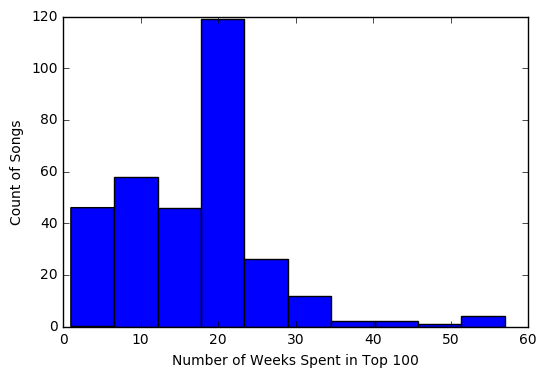

In [765]:
plt.hist(unique_tracks['weeks_in_top_hun'])
plt.xlabel("Number of Weeks Spent in Top 100")
plt.ylabel("Count of Songs")
plt.show()

Although the average duration for a track to spend in the top 100 is 16 weeks, distribution is skewed right, with the the most songs lasting 20 weeks or fewer, and only a few lasting between 30 and 60 weeks.

In [769]:
# Descriptive stats for duration in top 100
print "Maximum: ", max(top_tracks['weeks_in_top_hun'])
print "Minumum: ", min(top_tracks['weeks_in_top_hun'])
print "Mean: ", np.mean(top_tracks['weeks_in_top_hun'])
print "Median: ", np.median(top_tracks['weeks_in_top_hun'])
print "Mode: ", scipy.stats.mode(np.array(top_tracks['weeks_in_top_hun']))[0][0]
print "Standard Deviation: ", np.std(top_tracks['weeks_in_top_hun'])
print "Variance: ", np.var(top_tracks['weeks_in_top_hun'])

Maximum:  57
Minumum:  1
Mean:  16.8115015974
Median:  19.0
Mode:  20
Standard Deviation:  9.07615606561
Variance:  82.3766089273


### Which genre lasts the longest in the Billboard Top 100?

In [768]:
genre_weeks_in_hun = top_tracks.pivot_table(index = ['genre'], values = ['weeks_in_top_hun'], aggfunc = np.mean)
genre_weeks_in_hun.sort_values('weeks_in_top_hun', ascending = False)

weeks_in_top_hun
genre                        
Latin               19.222222
Rock                18.883212
Electronica         18.000000
Country             16.216216
Pop                 15.222222
Rap                 14.596491
R&B                 11.347826

In [791]:
# Calculate whether R&B songs spend significant less time in the Top 100 list than the average song
rb_dur = top_tracks[top_tracks['genre'] == "R&B"]
rb_dur = rb_dur['weeks_in_top_hun']
all_dur = top_tracks['weeks_in_top_hun']
scipy.stats.ttest_ind(rb_dur, all_dur)

Ttest_indResult(statistic=-2.8326655515243053, pvalue=0.0048964589179420039)

R&B tracks spend an average of only 11.3 weeks in the Top 100, significantly less than the general song list (p < 0.005)

### Which tracks rank the highest?

In [770]:
# Descriptive stats for track's maximum rank
print "Maximum: ", max(top_tracks['ranking'])
print "Minumum: ", min(top_tracks['ranking'])
print "Mean: ", np.mean(top_tracks['ranking'])
print "Median: ", np.median(top_tracks['ranking'])
print "Mode: ", scipy.stats.mode(np.array(top_tracks['ranking']))[0][0]
print "Standard Deviation: ", np.std(top_tracks['ranking'])
print "Variance: ", np.var(top_tracks['ranking'])

Maximum:  99.0
Minumum:  1.0
Mean:  44.0063897764
Median:  42.0
Mode:  1.0
Standard Deviation:  29.1321757725
Variance:  848.683665241


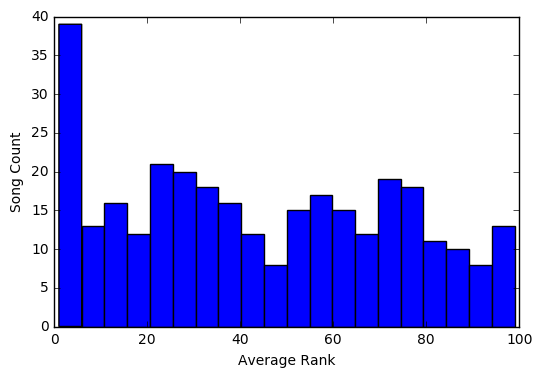

In [781]:
plt.hist(top_tracks['ranking'],20)
plt.xlabel('Average Rank')
plt.ylabel('Song Count')
plt.xlim(0,100)
plt.show()

Although the mean maximum ranking for all tracks is 43.9, because the mode is 1, we know that many songs achieve the number one spot over the course of a year. We can infer that there is a significant amount of turnover for the number one spot, and it isn't dominated by a single song for long.

In [772]:
top_tracks.pivot_table(index = ['genre'], values = ['ranking']).sort_values('ranking', ascending = False)

ranking
genre                 
R&B          59.304348
Rap          51.614035
Country      49.554054
Electronica  49.250000
Pop          42.111111
Rock         36.072993
Latin        31.444444

In [786]:
# Evaluate whether the ranking of R&B tracks is significantly than the average
rb_rank = top_tracks[top_tracks['genre']== "R&B"]
rb_rank = list(rb_rank['ranking'])
all_rank = list(top_tracks['ranking'])
scipy.stats.ttest_ind(rb_rank,all_rank)

Ttest_indResult(statistic=2.4441792192740746, pvalue=0.01503493154493676)

R&B tracks have a higher average ranking than the general track list (p < 0.05).

### How long do most tracks take to peak?

In [773]:
# Descriptive stats for time til peak
print "Maximum: ", max(top_tracks['days_til_peak'])
print "Minumum: ", min(top_tracks['days_til_peak'])
print "Mean: ", np.mean(top_tracks['days_til_peak'])
print "Median: ", np.median(top_tracks['days_til_peak'])
print "Mode: ", scipy.stats.mode(np.array(top_tracks['days_til_peak']))[0][0]
print "Standard Deviation: ", np.std(top_tracks['days_til_peak'])
print "Variance: ", np.var(top_tracks['days_til_peak'])

Maximum:  315.0
Minumum:  0.0
Mean:  52.5335463259
Median:  49.0
Mode:  49.0
Standard Deviation:  40.920553346
Variance:  1674.49168615


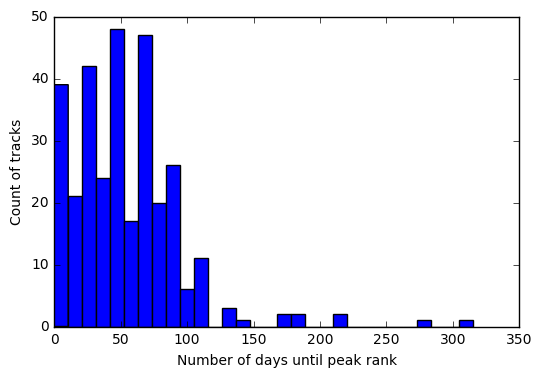

In [774]:
plt.hist(top_tracks['days_til_peak'], 30)
plt.xlabel("Number of days until peak rank")
plt.ylabel("Count of tracks")
plt.show()

The vast majority of songs peak under 100 days into their time in the Top 100 list. 

In [775]:
peak_genre = top_tracks.pivot_table(index = ['genre'], values = ['days_til_peak'], aggfunc = np.mean)
peak_genre.sort_values('days_til_peak')

days_til_peak
genre                     
R&B              28.608696
Rap              42.000000
Pop              47.444444
Rock             57.072993
Country          58.364865
Electronica      61.250000
Latin            64.555556

R&B songs peak more quickly than other songs (p < 0.01), but we should keep in mind that R&B also had fewer weeks on average in the top 100 than other genres.

In [794]:
rb_peak = top_tracks[top_tracks['genre']== "R&B"]
rb_peak = list(rb_peak['days_til_peak'])
all_peak = list(top_tracks['days_til_peak'])
scipy.stats.ttest_ind(rb_peak,all_peak)

Ttest_indResult(statistic=-2.7614972407535179, pvalue=0.0060718476019232673)

### Is there a seasonal aspect to when songs peak?

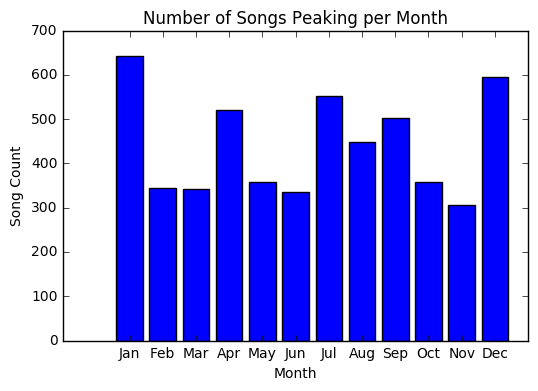

In [776]:
# Count number of songs peaking in each month and put in new list
peak_months = billboard['month.peaked'].value_counts()
peak_months = list(peak_months.sort_index())
peak_month_df = pd.DataFrame(columns = ['month', 'num_songs'])
months = ['Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
peak_month_df['month'] = months
peak_month_df['num_songs'] = peak_months
peak_month_df
# Plot peak songs per month
plt.bar(range(len(peak_month_df['month'])), peak_month_df['num_songs'], align = 'center')
plt.xticks(range(len(peak_month_df['month'])), peak_month_df['month'])
plt.xlabel('Month')
plt.ylabel('Song Count')
plt.title('Number of Songs Peaking per Month')
plt.show()

It looks like January and December are the months with the most peak songs, but there may be some truth behind the idea of "summer jams" as many songs also seem to hit maximum ranking from July to September as well.

### How did different genres fare over the 76 weeks?

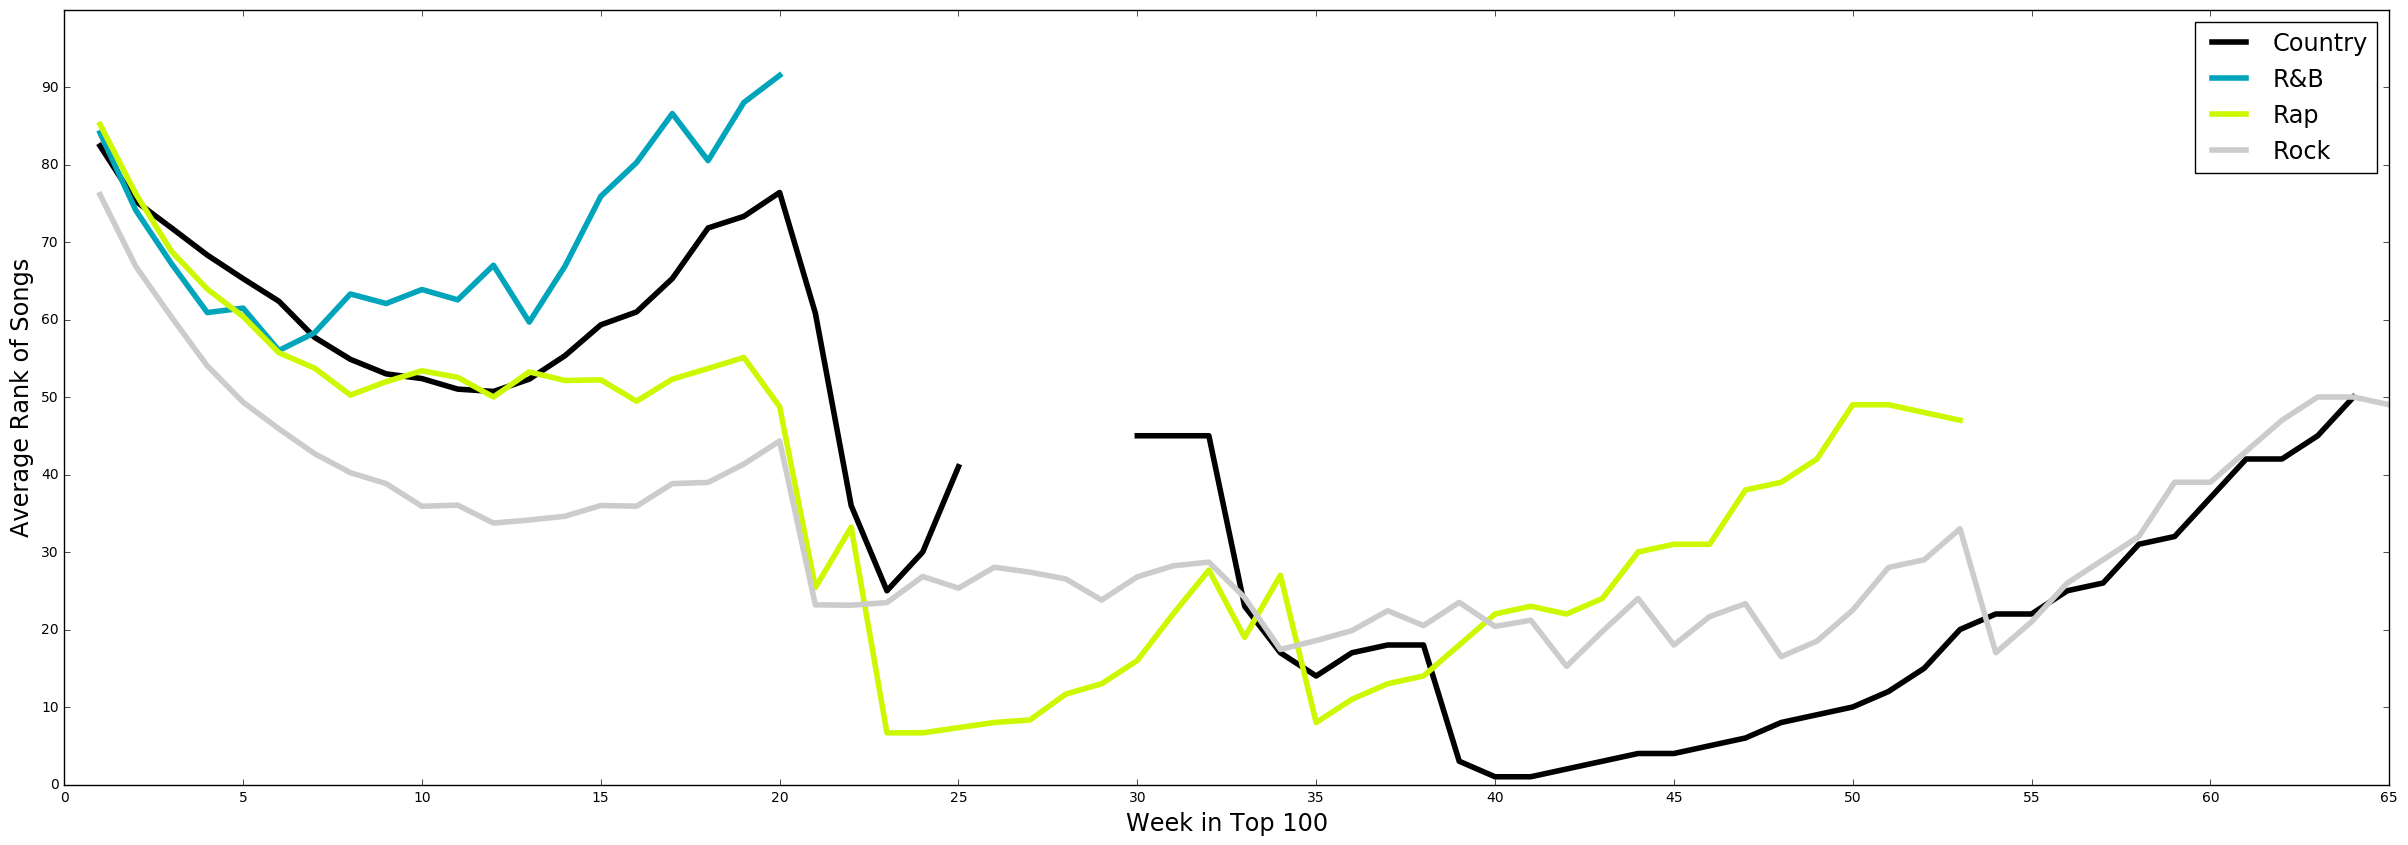

In [777]:
billboard_top_four = billboard[(billboard['genre'] == 'Rock') | (billboard['genre'] == 'Country') 
                         | (billboard['genre'] == 'Rap')|(billboard['genre'] == 'R&B')]
week_rank = billboard_top_four.pivot_table(index = ['week'], values = 'ranking', columns = 'genre')
# Graph ranking over time
wk_rk_plot = week_rank.plot(figsize = (30,10), xticks = (range(0,70,5)), yticks = (range(0,100,10)), 
                            colormap = 'nipy_spectral', lw = 4)
wk_rk_plot.legend(fontsize = 'xx-large')
wk_rk_plot.set_ylabel('Average Rank of Songs', fontsize = 'xx-large')
wk_rk_plot.set_xlabel('Week in Top 100', fontsize = 'xx-large')
plt.show()

This plot lists the average ranking of all songs in the top four most represented genres over 76 weeks. From this, we can see that the genres that ranked the highest did not necessarily have the longest time on the list. All four genres have a characteristic 'U-shape' to their ranking in the first 20 weeks. However, R&B tracks seem to fall off the chart after their peak, while the other three genres stay in the top 100 for longer, but achieve lower weekly rankings. This may explain why R&B tracks have the highest average ranking: they don't stay on the chart long enough to see mediocrity.

## Conclusions

In [778]:
# song with the longest tenure on the chart
print(billboard.sort_values('weeks_in_top_hun', ascending = False).iloc[0])

track                            Higher
artist                            Creed
year                               2000
time                               5:16
genre                              Rock
date.entered        1999-09-11 00:00:00
date.peaked         2000-07-22 00:00:00
month.peaked                         07
weeks_in_top_hun                     57
days_til_peak                       315
week                                 36
ranking                              16
Name: 11141, dtype: object


In [779]:
# song with highest average rating
song_ranking = billboard.pivot_table(index = ['track', 'artist'], values = 'ranking', aggfunc = np.mean)
song_ranking.sort_values().head()

track                     artist                      
Maria, Maria              Santana                         10.500000
Music                     Madonna                         13.458333
Bye Bye Bye               N'Sync                          14.260870
Hot Boyz                  Elliott, Missy "Misdemeanor"    14.333333
Independent Women Part I  Destiny's Child                 14.821429
Name: ranking, dtype: float64

In [780]:
# song with quickest rise to peak
peak_song = unique_tracks.pivot_table(index = ['track', 'artist','genre'],values = 'days_til_peak')
peak_song.sort_values().head(20)

track                  artist            genre  
If I Am                Nine Days         Rock       0.0
Freakin' It            Smith, Will       Rap        0.0
Got Beef               Eastsidaz, The    Rap        0.0
Crybaby                Carey, Mariah     Rock       0.0
I Know                 Tuesday           Rock       0.0
I'm Outta Love         Anastacia         Pop        0.0
Cherchez LaGhost       Ghostface Killah  R&B        0.0
Kernkraft 400          Zombie Nation     Rock       0.0
Can't Stay             Hollister, Dave   Rock       0.0
Breathe And Stop       Q-Tip             Rock       0.0
Nothing As It Seems    Pearl Jam         Rock       0.0
Toca's Miracle         Fragma            R&B        0.0
Riddle                 En Vogue          Rock       0.0
Sleepwalker            Wallflowers, The  Rock       0.0
No Me Dejes De Querer  Estefan, Gloria   Rock       0.0
All Good?              De La Soul        Rap        0.0
Souljas                Master P          Rap        0.0

### Most Popular Tracks
* Longest Duration in the Top 100: "Higher" by Creed
* Highest Average Ranking: "Maria, Maria" by Santana
* Shortest Time Til Peak: 11 of the 19 songs that achieved peak rank in their first week were Rock

### Most Popular Genres (for those with n > 1)
* Most Songs in Top 100: Rock
* Longest Average Time in Top 100: Latin
* Highest Average Ranking: R&B
* Shortest Time Til Peak: R&B




We can conclude that there are several ways to assess popularity of songs on the Billboard Top 100 list, and that no one genre dominates in longevity, number of songs on the list, or average ranking. Although Rock has the most songs and the longest average duration on the list, R&B songs tend to rank higher and peak more quickly. Demographic info on the average listener to either of these genres may contribute more insight into the different ranking patterns of songs in these two genres.